# Notebook per download automatico di immagini
L'utilizzo prevede di essere loggati su https://www.sentinel-hub.com/index.html
Il login dovrebbe automaticamente aprire la dashboard, dove si può aggiungere un OAuth client da User settings -> OAuth clients (tab a destra) -> create
Quando il client viene creato compaiono un client ID e un client secret, che vanno copiati e incollati nella cella qua sotto.

Il client ha un limite temporale, se il tentativo di download dà un errore probabilmente è perchè il client è scaduto, ne va creato uno nuovo.

In [ ]:
# Uncomment to run on colab
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/flood_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/flood_data'
/content/drive/MyDrive/flood_data


In [ ]:
!pip install sentinelhub


In [ ]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = '1504a94e-4e36-47f7-8439-0e35360d51d6'
config.sh_client_secret = '75P0m1QFppqYNSchtuZI6RI9DtogLwvs'

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import geopandas as gpd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

Queste sono le funzioni che avevo definito nel notebook precedente per normalizzare le bande e calcolare il Modified Normalized Difference Water Index (MNDWI)

In [ ]:
def normalize(band_green, band_swir):
    #Calculate maximum values for each raster file
    max_value = band_green.max()
    max_value = band_swir.max()

    #Normalize raster data to 0-255 scale
    scaled_band_green = (band_green / max_value) * 255
    scaled_band_swir = (band_swir/ max_value) * 255

    return scaled_band_green, scaled_band_swir


#Calculate MNDWI value for given images
def mndwi(scaled_band_green, scaled_band_swir):
    mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)
    return mndwi

## Lettura del file geojson
Qui leggo il file e costruisco un oggetto BBox con le coordinate. Bisogna mettere il path corretto ed eventualmente cambiare il file per cambiare sito.

In [ ]:
# Read the GeoJSON file
geojson_path = 'polygons_geojson/Oristano_small.geojson'
gdf = gpd.read_file(geojson_path)

# Extract the bounding box from the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds
bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)

In [ ]:
# resolution=20 corrisponde alla risoluzione 20m, sono i pacchetti che ci interessano perchè hanno anche l'immagine SCL
image_size = bbox_to_dimensions(bbox, resolution=20)

print(f"Image shape at  m resolution: {image_size} pixels")

Image shape at  m resolution: (1038, 977) pixels


## Funzione per richiedere al database l'immagine
Questa è la funzione che scarica i dati da creodias. Sto richiedendo banda 3, banda 11, e SCL. L'output è un dizionario che contiene le due bande e l'immagine SCL. Per ottenere altre bande è sufficiente modificare input, output e return della parte in rosso. `mosaicking_order` permette di selezionare automaticamente le immagini con minore copertura di nuvole, ho inoltre settato una soglia di maximum cloud coverage con `maxcc`

In [ ]:
# Define the request parameters for SCL data
def create_request(date_range):
    return SentinelHubRequest(
        data_folder='./temp_data/',
        evalscript="""
            //VERSION=3
            function setup() {
                return {
                    input: ["B03", "B11", "SCL"],
                    output: [
                        { id: "bands", bands: 2, sampleType: SampleType.FLOAT32 },
                        { id: "scl", bands: 1, sampleType: SampleType.UINT8 }
                    ]
                };
            }
            function evaluatePixel(sample) {
                return {
                    bands: [sample.B03*10000, sample.B11*10000],
                    scl: [sample.SCL]
                };
            }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=date_range,
                mosaicking_order='leastCC',
                maxcc=0.05  # Maximum cloud coverage of 10%
            )
        ],
        responses=[
            SentinelHubRequest.output_response('bands', MimeType.TIFF),
            SentinelHubRequest.output_response('scl', MimeType.TIFF)
        ],
        bbox=bbox,
        size=bbox_to_dimensions(bbox, resolution=10),
        config=config
    )

A questo punto specifico un time range a cui fare riferimento, e poi uso la funzione `create_request` definita sopra e salvo il dizionario risultante in `image_data`:

In [ ]:
# Request SCL data for a specific date range
date_range = ('2024-01-01', '2024-03-31')
request = create_request(date_range)
image_data = request.get_data()[0]

In [ ]:
image_data.keys()

dict_keys(['bands.tif', 'scl.tif'])

## Plot dell'immagine
Qui faccio un plot dell'immagine SCL, usando colori definiti in `scl_colors` per le diverse categorie

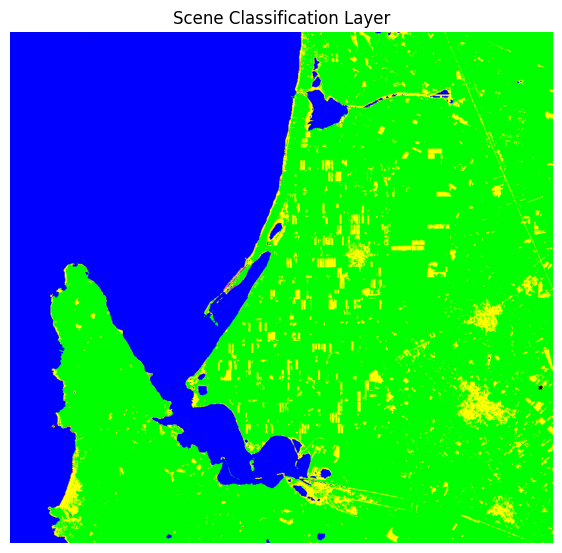

In [ ]:
# Separate the bands and SCL images
bands_image = image_data['bands.tif']
scl_image = image_data['scl.tif']

# Extract the bands
band_b03 = bands_image[:, :, 0]
band_b11 = bands_image[:, :, 1]
scl_data = scl_image

# Define the color map for SCL visualization
scl_colors = {
    0: (0, 0, 0),       # No data
    1: (255, 255, 255), # Saturated/defective
    2: (0, 0, 255),     # Dark area pixels
    3: (0, 255, 255),   # Cloud shadows
    4: (0, 255, 0),     # Vegetation
    5: (255, 255, 0),   # Bare soils
    6: (0, 0, 255),     # Water
    7: (255, 0, 255),   # Cloud low probability
    8: (255, 0, 0),     # Cloud medium probability
    9: (255, 255, 255), # Cloud high probability
    10: (0, 0, 0),      # Thin cirrus
    11: (255, 0, 0),    # Snow/ice
}

# Create a color-mapped image for SCL
scl_colored = np.zeros((scl_data.shape[0], scl_data.shape[1], 3), dtype=np.uint8)
for scl_value, color in scl_colors.items():
    mask = scl_data == scl_value
    scl_colored[mask] = color
# Plot the SCL image
plt.figure(figsize=(7, 7))
plt.imshow(scl_colored)
plt.title('Scene Classification Layer')
plt.axis('off')
plt.show()


E qui invece plotto usando le bande 3 e 11

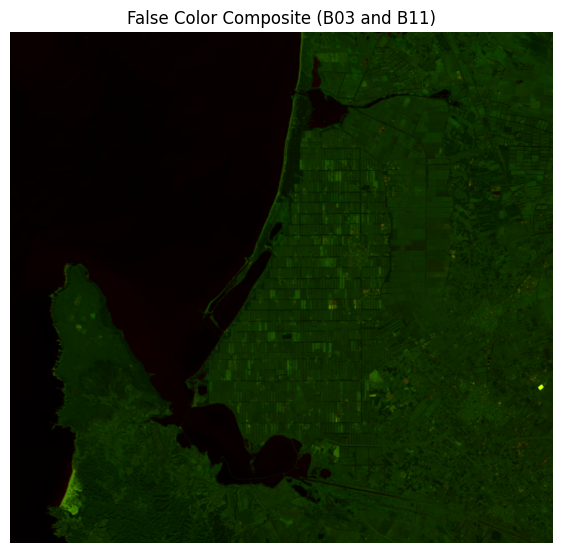

In [ ]:
# Plot the combination of B03 and B11 bands
plt.figure(figsize=(7,7))
plt.imshow(np.stack([band_b03/10000, band_b11/10000, np.zeros_like(band_b03)], axis=-1))
plt.title('False Color Composite (B03 and B11)')
plt.axis('off')
plt.show()

Qui ripeto le operazioni che avevamo fatto nell'altro notebook, giusto per controllare che tutto stia funzionando come prima

In [ ]:
band_green_b, band_swir_b = normalize(band_b03, band_b11)
mndwi_b = mndwi(band_green_b, band_swir_b)

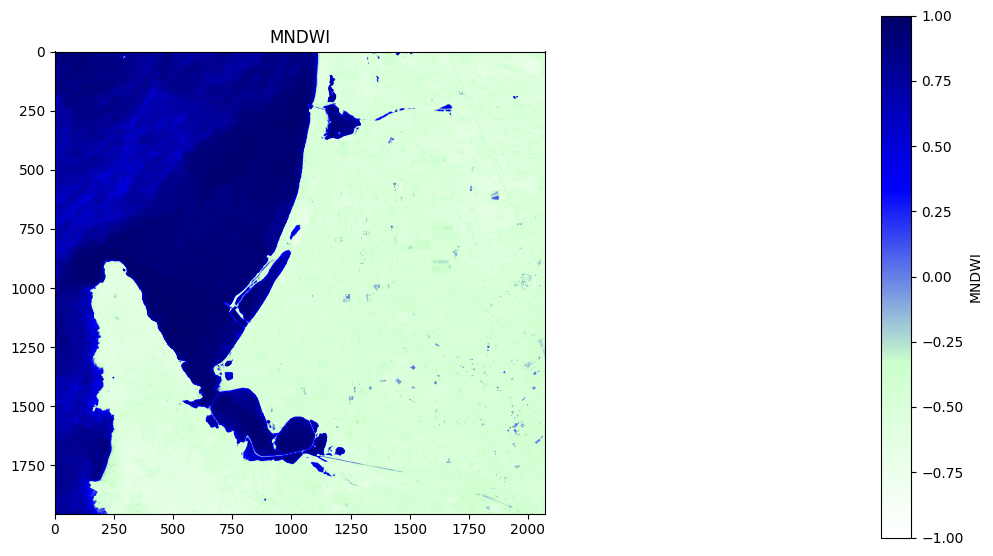

In [ ]:
# Define a colormap that transitions from white to light green to blue to dark navy blue
colors = [(1, 1, 1), (0.8, 1, 0.8), (0, 0, 1), (0, 0, 0.4)]  # (R, G, B)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

vmin, vmax = -1, 1
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharey=True)
im = ax1.imshow(mndwi_b, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('MNDWI')
fig.subplots_adjust(wspace=0.05, right=0.8)  # Reduce space between axes and make room for colorbar
cbar_ax = fig.add_axes([0.85, 0.07, 0.02, 0.87])  # Position and size of colorbar [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='MNDWI')
plt.show()

# Download multipli
Qui utilizzo un approccio simile a sopra, ma applicato a un range temporale molto più lungo. `start` e `end` sono inizio e fine del range temporale, `n_chunks` corrisponde circa al numero di mesi considerato, per suddividere ulteriormente in slot.

In [ ]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 6, 1)
n_chunks = 12*6+6
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

In [ ]:
# Le date possono anche essere definite così, se ad esempio si vogliono slot temporali discontinue:
# dates = [
#     ('2023-01-01', '2023-01-31'),
#     ('2023-02-01', '2023-02-28'),
#     ('2023-03-01', '2023-03-31'),
#     # Add more dates as needed
# ]

In [ ]:
def get_request2(time_interval):
    return SentinelHubRequest(
       evalscript="""
            //VERSION=3
            function setup() {
                return {
                    input: ["B03", "B11", "SCL"],
                    output: [
                        { id: "bands", bands: 2, sampleType: SampleType.FLOAT32 },
                        { id: "scl", bands: 1, sampleType: SampleType.UINT8 }
                    ]
                };
            }
            function evaluatePixel(sample) {
                return {
                    bands: [sample.B03*10000, sample.B11*10000],
                    scl: [sample.SCL]
                };
            }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order='leastCC',
                maxcc=0.05  # Maximum cloud coverage of 10%
            )
        ],
        responses=[
            SentinelHubRequest.output_response('bands', MimeType.TIFF),
            SentinelHubRequest.output_response('scl', MimeType.TIFF)
        ],
        bbox=bbox,
        size=bbox_to_dimensions(bbox, resolution=10),
        config=config
    )

Utilizzo la funzione definita sopra per creare una lista di richieste, e poi scarico le immagini e le metto in `data`. Nota: questo step crea una cartella `temp_data` dove vengono scaricate tutte le immagini in formato zip. Per evitare di sovraccaricare il drive suggerisco di cancellare la cartella una volta che il risultato è consolidato.

In [ ]:
# create a list of requests
list_of_requests = [create_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

/usr/local/lib/python3.10/dist-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/usr/local/lib/python3.10/dist-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/usr/local/lib/python3.10/dist-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/usr/local/lib/python3.10/dist-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/usr/local/lib/python3.10/dist-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRat

In [ ]:
len(data)

77

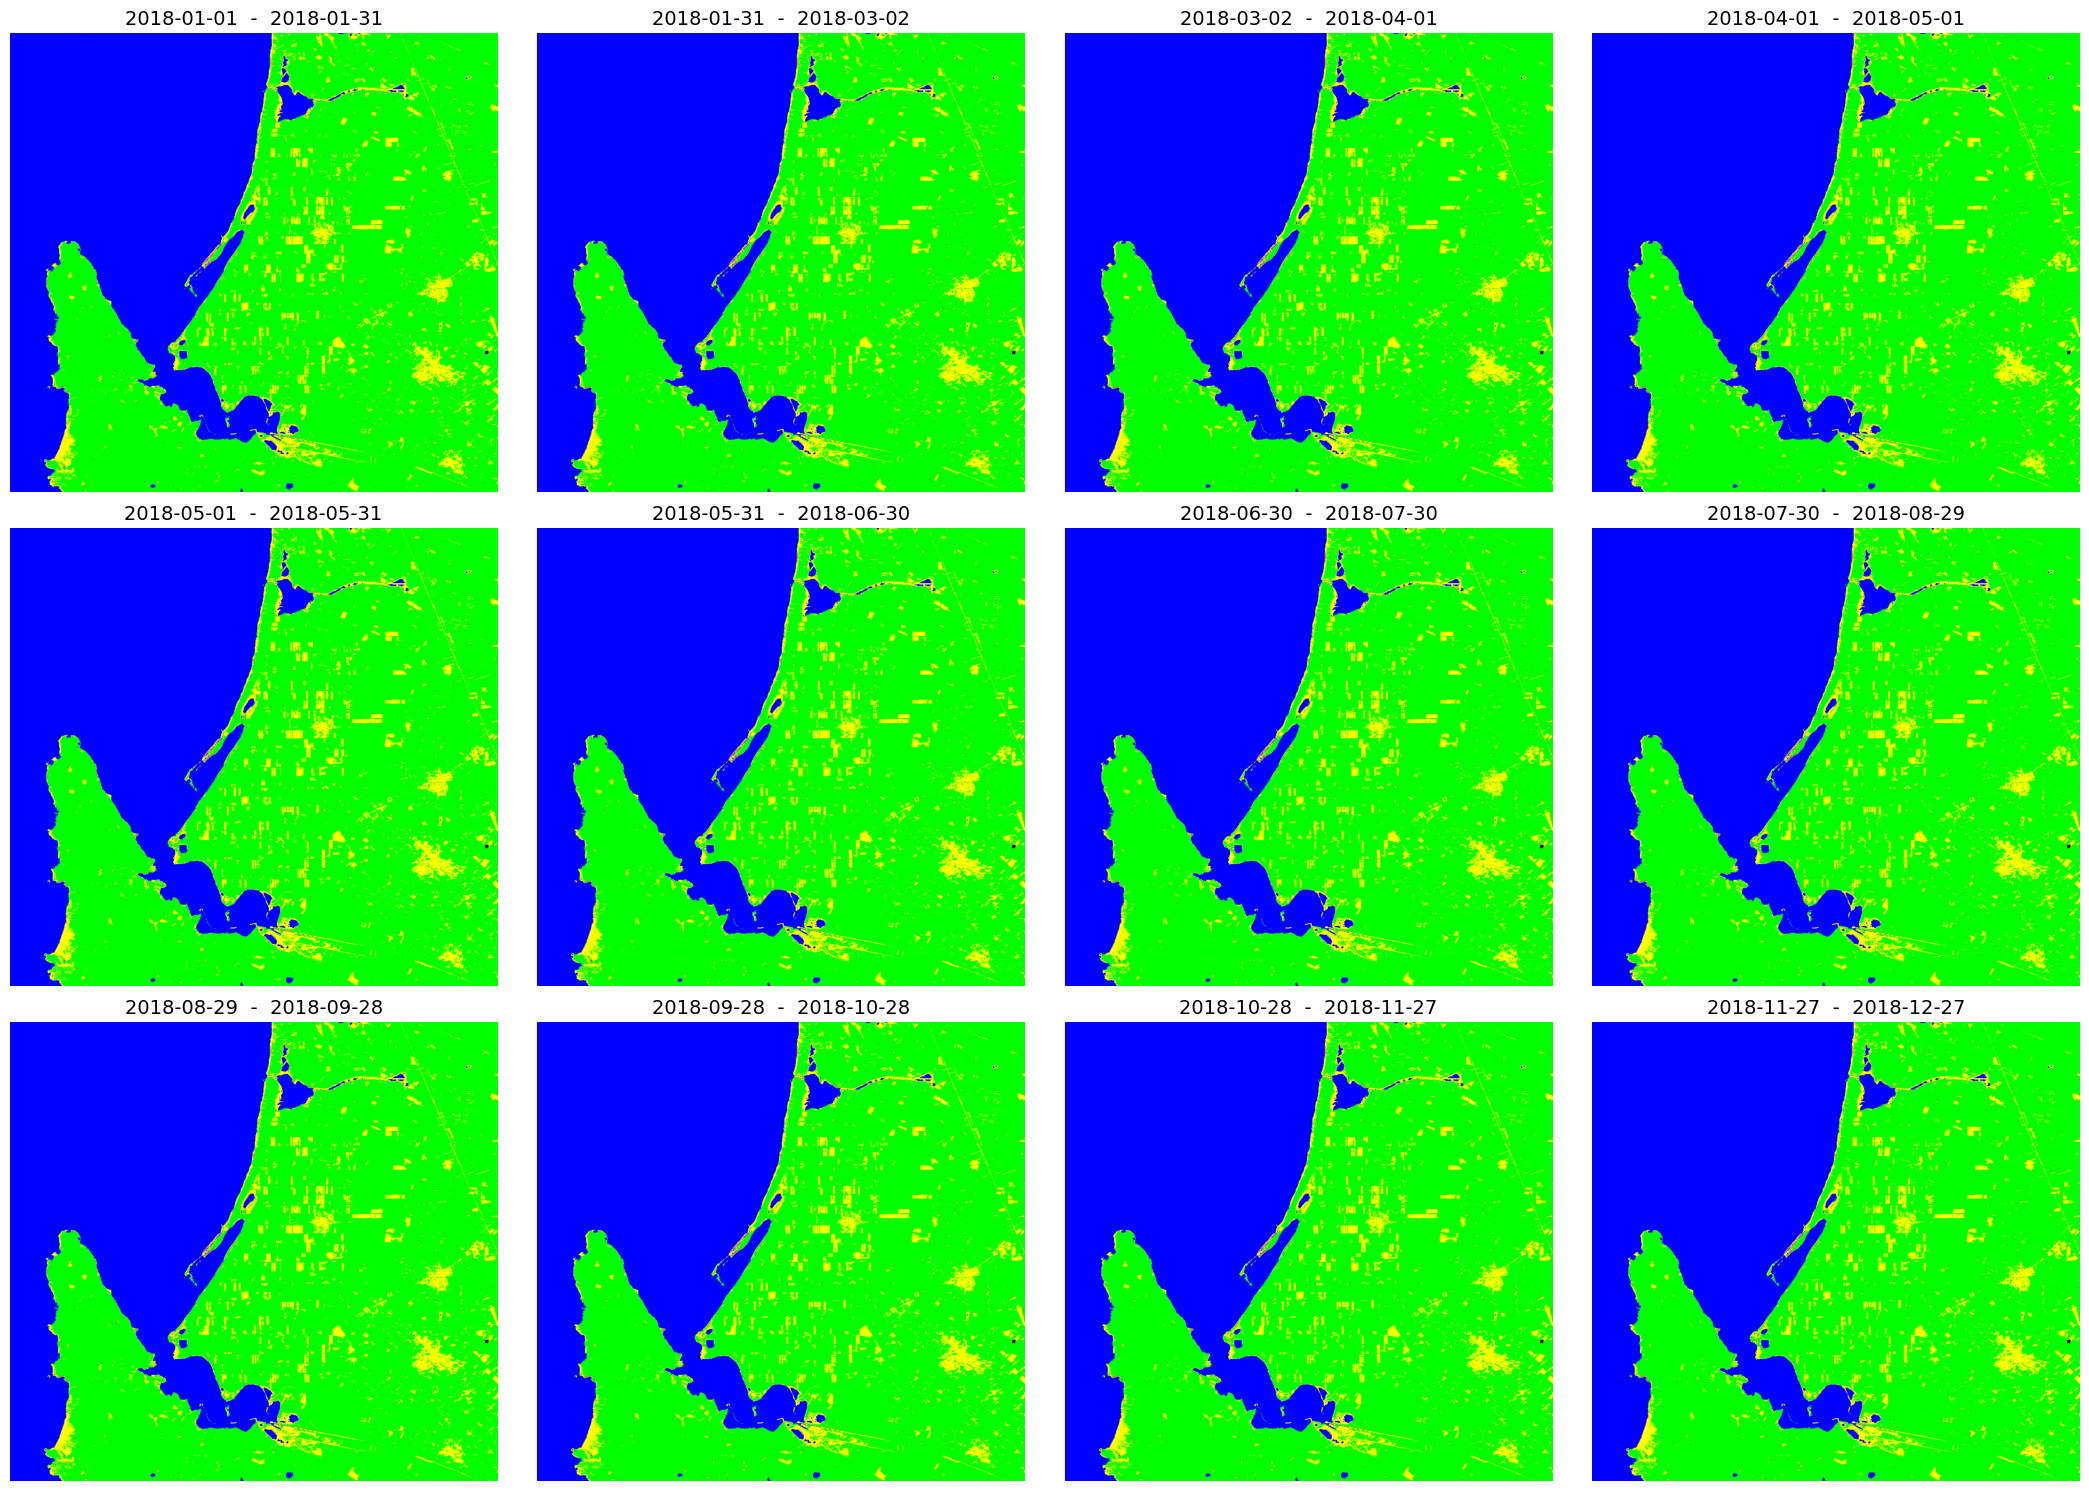

In [ ]:
# Plotto alcune delle immagini ottenute
ncols = 4
nrows = 3
aspect_ratio = image_size[0] / image_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data[0:12]):
    ax = axs[idx // ncols][idx % ncols]
    scl_colored = np.zeros((data[idx]['scl.tif'].shape[0], data[idx]['scl.tif'].shape[1], 3), dtype=np.uint8)
    for scl_value, color in scl_colors.items():
        mask = scl_data == scl_value
        scl_colored[mask] = color
    ax.imshow(scl_colored)
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=14)

plt.tight_layout()

Ora faccio un confronto tra due immagini riferite a time slot diverse

In [ ]:
band_green_b, band_swir_b = normalize(data[17]['bands.tif'][:,:,0], data[17]['bands.tif'][:,:,1])
band_green_f, band_swir_f = normalize(data[37]['bands.tif'][:,:,0], data[37]['bands.tif'][:,:,1])

mndwi_b = mndwi(band_green_b, band_swir_b)
mndwi_f = mndwi(band_green_f, band_swir_f)

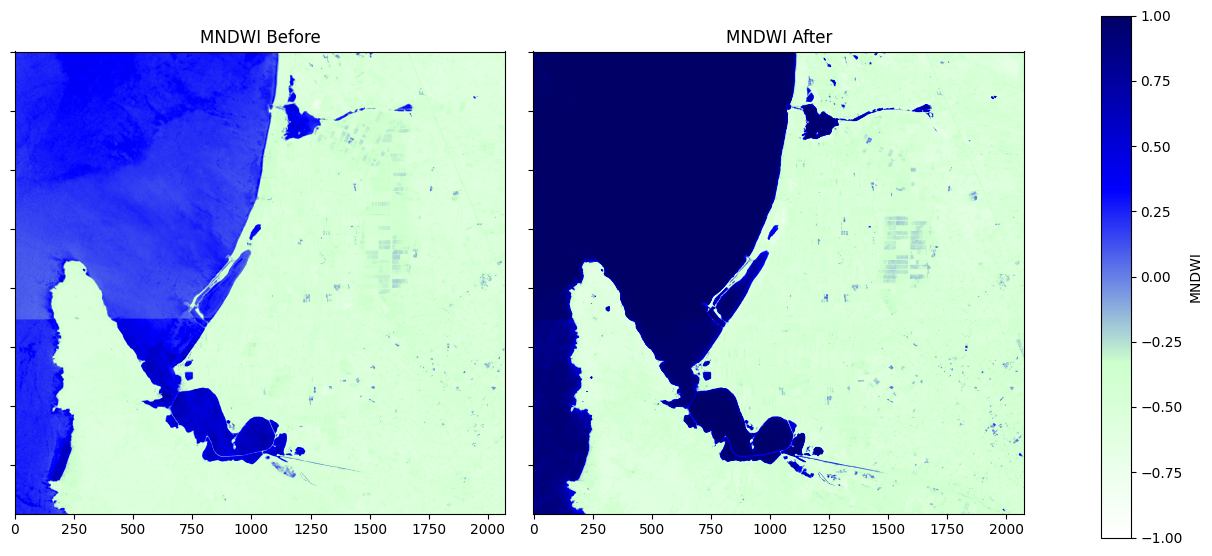

In [ ]:
# Define a colormap that transitions from white to light green to blue to dark navy blue
colors = [(1, 1, 1), (0.8, 1, 0.8), (0, 0, 1), (0, 0, 0.4)]  # (R, G, B)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

vmin, vmax = -1, 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
im = ax1.imshow(mndwi_b, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('MNDWI Before')
ax2.imshow(mndwi_f, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title('MNDWI After')
ax2.set_yticklabels([])
fig.subplots_adjust(wspace=0.05, right=0.8)  # Reduce space between axes and make room for colorbar
cbar_ax = fig.add_axes([0.85, 0.07, 0.02, 0.87])  # Position and size of colorbar [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='MNDWI')
plt.show()

In [ ]:
# scl_b = data[15]['scl.tif']
# scl_f = data[27]['scl.tif']

In [ ]:
# # Create mask by SCL values
# mask_f = np.logical_or(scl_f == 8, np.logical_or(scl_f == 9, scl_f == 3))
# mask_b = np.logical_or(scl_b == 8, np.logical_or(scl_b == 9, scl_b == 3))
# # Calculate difference between flood period and normal period
# diff = mndwi_f - mndwi_b

# #Calculate water tides by showing the pixels that have positive difference values
# tide = diff
# tide[(diff < 0)] = 0
# tide[mask_f | mask_b] = 0
# tide = tide / tide.max()

# #Calculate flood areas by showing the pixcels that have possitive difference values and had negative values of MNDWI before flood
# flood = diff
# flood[(diff < 0) | (mndwi_b > 0)] = 0
# flood[mask_f | mask_b] = 0
# flood = flood / flood.max()

In [ ]:
# # Define a colormap that goes from yellow to red with transparency for 0 values and violet for high values
# colors = [(1, 1, 0, 0), (1, 0.5, 0, 1), (1, 0, 0, 1), (0.5, 0, 0.5, 1)]  # (R, G, B, Alpha)
# cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)


# vmin, vmax = 0, 1
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# im1 = ax1.imshow(tide, cmap=cmap, vmin=vmin, vmax=np.max(tide))
# ax1.set_title('Water tides')
# cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
# cbar1.set_label('Tide')

# im2 = ax2.imshow(flood, cmap=cmap, vmin=vmin, vmax=np.max(flood))
# ax2.set_title('Flood areas')
# cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
# cbar2.set_label('Flood')
# plt.tight_layout()  # Adjust the rect to prevent the tight_layout affecting the colorbar
# plt.show()



In [ ]:
# Process the data for each date range
water_data_over_time = []

for i in range(len(data)):
    band_b03 = data[i]['bands.tif'][:,:,0]
    band_b11 = data[i]['bands.tif'][:,:,1]
    scl = data[i]['scl.tif']
    scl_identification = np.sum(scl==6)/scl.size

    b3_norm, b11_norm = normalize(band_b03, band_b11)
    mndwi_i = mndwi(b3_norm, b11_norm)
    mndwi_coverage = np.sum(mndwi_i>0)/mndwi_i.size
    water_data_over_time.append((slots[i][0], mndwi_coverage, scl_identification))

<ipython-input-20-43fd9dc7ea20>:7: RuntimeWarning: invalid value encountered in divide
  scaled_band_green = (band_green / max_value) * 255
<ipython-input-20-43fd9dc7ea20>:8: RuntimeWarning: invalid value encountered in divide
  scaled_band_swir = (band_swir/ max_value) * 255
<ipython-input-20-43fd9dc7ea20>:15: RuntimeWarning: invalid value encountered in divide
  mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)


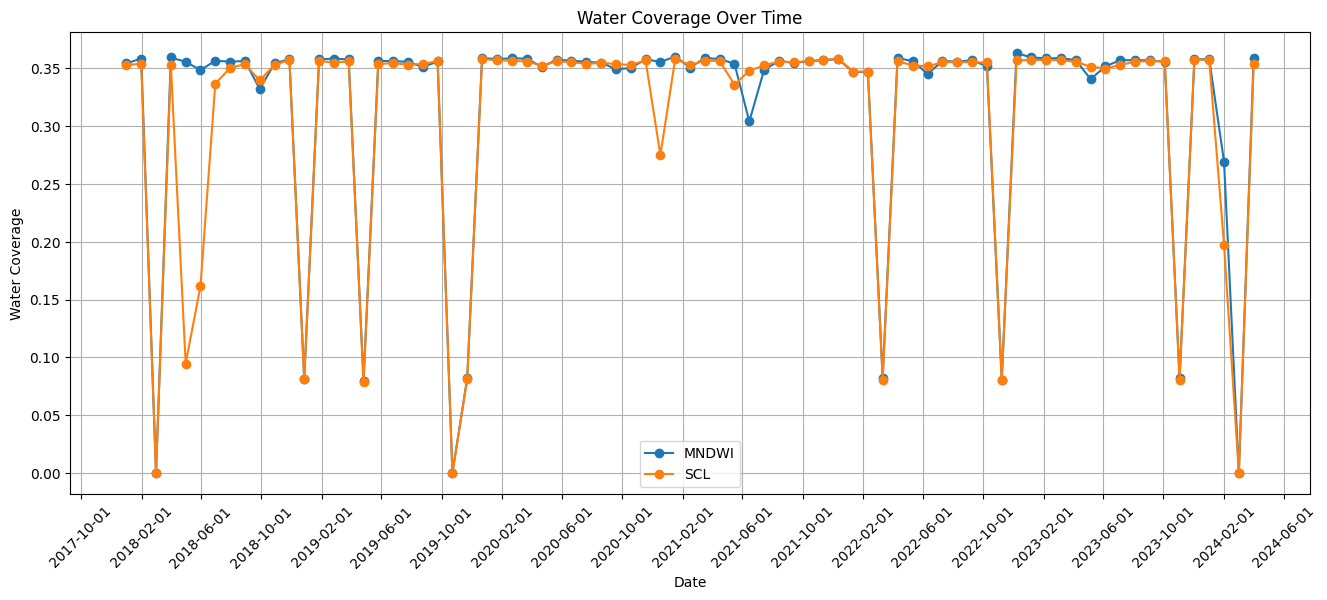

In [ ]:
import matplotlib.dates as mdates
import pandas as pd
# Plot water coverage over time
dates, mndwi_coverage, scl_coverage = zip(*water_data_over_time)
dates = pd.to_datetime(dates)

plt.figure(figsize=(16, 6))
plt.plot(dates, mndwi_coverage, marker='o', label=r'MNDWI')
plt.plot(dates, scl_coverage, marker='o', label=r'SCL')
plt.xlabel('Date')
plt.ylabel('Water Coverage')
plt.title('Water Coverage Over Time')
plt.grid()
# Format the x-axis with fewer ticks and rotate labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.legend()
plt.show()
